In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
from util import random_mini_batches

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

st = tf.contrib.bayesflow.stochastic_tensor
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class DenseLayer(object):
    
    def __init__(self, mi, mo, f=tf.nn.relu):
        
        #self.mi = mi
        #self.mo = mo
        
        self.W = tf.Variable(tf.random_normal(shape=(mi,mo))*2/np.sqrt(mi))
        self.b = tf.Variable(np.zeros(mo).astype(np.float32))
        self.f = f
        
    def forward(self, X):
        
        return self.f(tf.matmul(X,self.W) + self.b)
    
    def set_session(self, session):
        
        self.session = session

In [3]:
class VariationalAutoencoder:
    
    
    def __init__(self, D, hidden_layer_sizes):
        
        #size of every layer in the encoder
        #up to the latent layer, decoder
        #will have reverse shape
        
        self.encoder_layers = []
        self.decoder_layers = []
        
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        #build encoder
        M_in = D
        for M_out in hidden_layer_sizes[:-1]:
            layer = DenseLayer(M_in, M_out)
            self.encoder_layers.append(layer)
            M_in = M_out
        
        #no activation of last layer and need 2
        #times as many units (M means and M stddevs)
        
        M = hidden_layer_sizes[-1]
        
        last_enc_layer = DenseLayer(M_in, 2*M, f=lambda x: x)
        self.encoder_layers.append(last_enc_layer)
        
        #propagate X until end of encoder
        current_layer_value=self.X
        
        for layer in self.encoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        
        #get means and stddev from last encoder layer
        self.means = current_layer_value[:, :M]
        self.stddev = tf.nn.softplus(current_layer_value[:,M:])+1e-6
        
        # get a sample of Z, we need to use a stochastic tensor
        # in order for the errors to be backpropagated past this point
        
        with st.value_type(st.SampleValue()):
            self.Z = st.StochasticTensor(Normal(loc=self.means, scale=self.stddev))
            
        #build decoder
        
        M_in = M
        for M_out in reversed(hidden_layer_sizes[:-1]):
            layer = DenseLayer(M_in, M_out)
            self.decoder_layers.append(layer)
            M_in = M_out

        # the decoder's final layer should technically go through a sigmoid
        # so that the final output is a binary probability (e.g. Bernoulli)
        # but Bernoulli accepts logits (pre-sigmoid) so we will take those
        # so no activation function is needed at the final layer
        last_dec_layer = DenseLayer(M_in, D, f=lambda x: x)
        self.decoder_layers.append(last_dec_layer)
        
        current_layer_value = self.Z
        
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        
        logits = current_layer_value
        posterior_predictive_logits = logits
        
        # get the output
        self.X_hat_distribution = Bernoulli(logits=logits)
        
        
        #the posterior predictive sample
        # take samples from X_hat
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)

        # the prior predictive sample
        # take sample from a Z ~ N(0, 1)
        # and put it through the decoder

        standard_normal = Normal(
          loc=np.zeros(M, dtype=np.float32),
          scale=np.ones(M, dtype=np.float32)
        )

        Z_std = standard_normal.sample(1)
        current_layer_value=Z_std
        
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
            
        logits = current_layer_value
        
        prior_predictive_dist = Bernoulli(logits=logits)
        self.prior_predictive = prior_predictive_dist.sample()
        self.prior_predictive_probs = tf.nn.sigmoid(logits)


        # prior predictive from input
        # only used for generating visualization
        self.Z_input = tf.placeholder(tf.float32, shape=(None, M))
        current_layer_value = self.Z_input
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
            
        logits = current_layer_value
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)


        # now build the cost
        kl = tf.reduce_sum(
            tf.contrib.distributions.kl_divergence(
                self.Z.distribution,
                standard_normal),
            1
        )
        
        
        expected_log_likelihood = tf.reduce_sum(
              self.X_hat_distribution.log_prob(self.X),
              1
        )
        
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(-self.elbo)

        
    def fit(self, X, epochs = 30, batch_sz = 64):
        costs = []
        n_batches = len(X)//batch_sz
        print("# batches", n_batches)
        
        for i in range(epochs):
            print("epoch", i)
            np.random.shuffle(X)
            
            for j in range(n_batches):
                
                X_batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c = self.session.run((self.train_op,self.elbo),feed_dict={self.X:X_batch})
                c /= batch_sz
                costs.append(c)
                
                if j % 250 == 0:
                    print("on iter %d, cost: %.3f" %(j, c))
                
            plt.plot(costs)
            plt.show
            
    def set_session(self, session):
        
        self.session = session
        
        for layer in self.encoder_layers:
            layer.set_session(session)
            
        for layer in self.decoder_layers:
            layer.set_session(session)  
    
    def transform(self, X):
        return self.session.run(
          self.means,
          feed_dict={self.X: X}
        )

    def prior_predictive_with_input(self, Z):
        return self.session.run(
          self.prior_predictive_from_input_probs,
          feed_dict={self.Z_input: Z}
        )

    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.session.run(self.posterior_predictive, feed_dict={self.X: X})

    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.session.run((self.prior_predictive, self.prior_predictive_probs))

In [ ]:
def test_vae():

    X_train = mnist.train.images
    #X_train = X_train/255
    X_train = (X_train>0.5).astype(np.float32)
    
    X_test = mnist.test.images
    #X_test = X_test/255
    X_test = (X_test>0.5).astype(np.float32)

    
    N, D = X_train.shape
    
    vae = VariationalAutoencoder(D, [300,200,100])
    # set up session and variables for later
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init_op)
        vae.set_session(sess)
        vae.fit(X_train)

        done = False
        while not done:
        
            i = np.random.choice(len(X_test))
            x = X_test[i]
            im = vae.posterior_predictive_sample([x]).reshape(28, 28)
            
            plt.subplot(1,2,1)
            plt.imshow(x.reshape(28, 28), cmap='gray')
            plt.title("Original")
            
            plt.subplot(1,2,2)
            plt.imshow(im, cmap='gray')
            plt.title("Sampled")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

  # plot output from random samples in latent space
        done = False
        while not done:
        
            im, probs = vae.prior_predictive_sample_with_probs()
            
            im = im.reshape(28, 28)
            
            probs = probs.reshape(28, 28)
            
            plt.subplot(1,2,1)
            plt.imshow(im, cmap='gray')
            plt.title("Prior predictive sample")
            
            plt.subplot(1,2,2)
            plt.imshow(probs, cmap='gray')
            plt.title("Prior predictive probs")
            plt.show()

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

# batches 859
epoch 0
on iter 0, cost: -2996.807
on iter 250, cost: -203.675
on iter 500, cost: -174.288
on iter 750, cost: -162.982
epoch 1
on iter 0, cost: -163.229
on iter 250, cost: -153.923
on iter 500, cost: -151.408
on iter 750, cost: -141.222
epoch 2
on iter 0, cost: -133.047
on iter 250, cost: -143.415
on iter 500, cost: -124.103
on iter 750, cost: -135.073
epoch 3
on iter 0, cost: -122.696
on iter 250, cost: -117.397
on iter 500, cost: -124.299
on iter 750, cost: -119.466
epoch 4
on iter 0, cost: -117.893
on iter 250, cost: -119.795
on iter 500, cost: -108.713
on iter 750, cost: -104.135
epoch 5
on iter 0, cost: -110.979
on iter 250, cost: -106.492
on iter 500, cost: -106.563
on iter 750, cost: -116.225
epoch 6
on iter 0, cost: -106.370
on iter 250, cost: -104.947
on iter 500, cost: -102.465
on iter 750, cost: -104.997
epoch 7
on iter 0, cost: -98.327
on iter 250, cost: -99.797
on iter 500, cost: -104.083
on iter 750, cost: -101.275
epoch 8
on iter 0, cost: -97.253
on iter 25

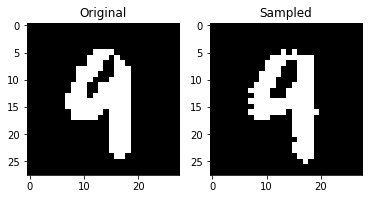

In [ ]:
if __name__=='__main__':
    test_vae()